# Module 6 Lab 3 - Random Forest to predict readmission

In this lab, we will attempt to predict readmissions using a random forest, and compare the results to previous methods.

Random forests are composed of many decision trees, and the resulting answer is a composition of each decision tree's answer, taken in aggregate.  Unlike a decision tree, a random forest is a "black box" model.  It is inherently unexplainable as a model because of the large volume of decision trees that make up a typical forest.  Each decision tree in the forest will also not be composed of all features.

See the TEDx video from Module 5 from Finale Doshi-Velez for methods to explain the results of black box AI models.

Random forests are appropriate when there are a large number of features.  Unlike in a regression model, where we sometimes need to reduce the number of features in the model, random forest can handle all fetures, thereby making use of the entire training data set.

In [1]:
import sys
# this version of sklearn includes the permutation_importance method used below, but needs numpy <1.20 to fix a bug
!{sys.executable} -m pip install --upgrade "scikit-learn>=1.0" "numpy<1.20"


     |████████████████████████████████| 23.0MB 3.0MB/s eta 0:00:01
     |████████████████████████████████| 14.8MB 13.0MB/s eta 0:00:01
     |████████████████████████████████| 307kB 16.0MB/s eta 0:00:01
  Found existing installation: numpy 1.17.3
    Uninstalling numpy-1.17.3:
      Successfully uninstalled numpy-1.17.3
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3


In [2]:
# this version of sklearn includes the permutation_importance method used below
import sklearn
sklearn.__version__

'1.0.2'

In [3]:
import numpy as np
import pandas as pd

In [4]:
%matplotlib inline

## Apply transformations to our data
These are the same transformations as applied to the logistic regression model.  See Lab 1 for more explanations.

In [5]:
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('../resources/diabetes_readmission.csv')
display(data.head())

y = data['readmitted']
X = data[['discharge', 'age', 'race', 'admission_type', 'specialty', 'time_in_hospital', 'diag_1', 'A1Cresult', 'change']].copy()

scaler = StandardScaler()
X['time_in_hospital'] = scaler.fit_transform(X[['time_in_hospital']])

# create dummy variables
X = pd.concat([X, pd.get_dummies(X['age'], prefix = 'age', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['race'], prefix = 'race', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['admission_type'], prefix = 'admission_type', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['specialty'], prefix = 'specialty', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['diag_1'], prefix = 'diag_1', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['A1Cresult'], prefix = 'A1Cresult', drop_first=True)], axis=1)

# drop originals
X = X.drop(['age', 'race', 'admission_type', 'specialty', 'diag_1', 'A1Cresult'], axis=1)

# balance the classes
display(y.value_counts())

X_oversampled, y_oversampled = resample(X[y == 1], y[y == 1], replace=True, n_samples=X[y == 0].shape[0], random_state=42)

X = pd.DataFrame(np.vstack((X[y == 0], X_oversampled)), columns=X.columns)
y = np.hstack((y[y == 0], y_oversampled))

display(pd.Series(y).value_counts())

,readmitted,discharge,age,race,admission_type,specialty,time_in_hospital,diag_1,A1Cresult,change
0,1,0,0,1,1,0,8,8,0,1
1,0,0,0,1,1,4,2,8,0,0
2,0,1,2,1,1,2,4,8,2,0
3,0,0,2,1,1,2,3,8,3,1
4,0,0,0,0,1,2,5,8,0,0


0    60145
1     5813
Name: readmitted, dtype: int64

1    60145
0    60145
dtype: int64

## Train the Random Forest
Here we are building the model using [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

We are setting the size of the forest to 500, so we will generate 500 decision trees containing randomly selected features that comprise the ensemble.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# train/test split, specify the seed for reproducible results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


model = RandomForestClassifier(n_estimators=500, random_state=42).fit(X_train, y_train)



## Visualize and compare the results

accuracy 0.6635429262394196


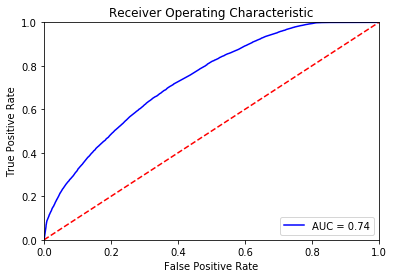

confusion matrix:
[[12662  7287]
 [ 6069 13678]]

classification report:
              precision    recall  f1-score   support

           0       0.68      0.63      0.65     19949
           1       0.65      0.69      0.67     19747

    accuracy                           0.66     39696
   macro avg       0.66      0.66      0.66     39696
weighted avg       0.66      0.66      0.66     39696



In [7]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

print('accuracy', model.score(X_test, y_test))

probs = model.predict_proba(X_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_pred = model.predict(X_test)

cmatrix = confusion_matrix(y_test, y_pred)
print('confusion matrix:')
print(cmatrix)
print('\nclassification report:')
print(classification_report(y_test, y_pred))

## Results
Both the ROC and Accuracy are higher than logistic regression and decision trees.  

The precision (the proportion of true positives out of all identified positives) is higher for the positive case over decision tree, and for the negative case it is equal.  This model performs better than the single decision tree, but it suffers because of it's black box nature, meaning the model itself is not inherently explainable.  Were we to use such a model, we can resort to the concepts of local explanation and local counterfactual faithfulness, as described by Doshi-Velez, and use methods to extract feature importances.



## Feature Importances

### Mean decrease in feature impurity
Getting feature importances from a random forest model can help explain how the model generally came to it's consclusion, although it is far from transparent.  Below we will plot the feature importances of the model we generated above using the mean decrease in feature impurity.  This measure is the average amount of decrease in impurity (or conversely the increase in information gain) across all trees in the forest.  It is essentially a measure of the pwoer of the feature to reduce uncertainty in the dataset, and is computed on a built random forest.

Text(0, 0.5, 'mean decrease in impurity')

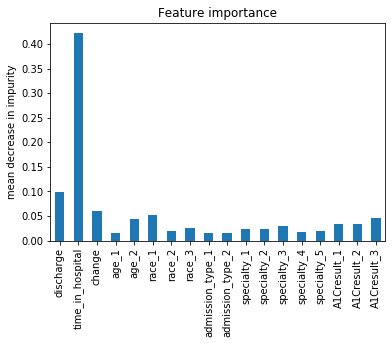

In [8]:
importances = pd.Series(model.feature_importances_, index=X_test.columns.values.tolist())

ax = importances.plot.bar()
ax.set_title("Feature importance")
ax.set_ylabel("mean decrease in impurity")


### Feature permutation
The previous method is not robust to high cardinality features.  An alternative method that is robust is feature permutation.  This method is calculated against a hold out or test set using the built model.  The model is run on the held out set of data, and the features are permuted (the values of the features are no longer associated with the original row and the original class label) to see the result on the specified scoring method we choose.  The larger the difference in the score when a feature is changed, the more important that feature is deemed to be.

We use [sci-kit learn's implementation](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance) to get the feature permutation.  We specify accuracy as the score to use, but [other scorers are available](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

This will take a few minutes to run and calculate the importances.  The time can be shortened by using a smaller value for `n_repeats`, but the importances may not be as accurate.  We also specify with `n_jobs=-1` to use all available cpus.

Text(0, 0.5, 'mean decrease in accuracy')

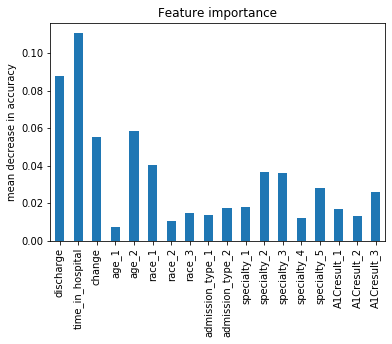

In [9]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=5, n_jobs=-1, scoring='accuracy')
importances = pd.Series(result.importances_mean, index=X_test.columns)

ax = importances.plot.bar()
ax.set_title("Feature importance")
ax.set_ylabel("mean decrease in accuracy")

We can see that the feature permutation does differ from the mean decrease in impurity.  This method would represent the actual feature importances based on the hold-out or test set, whereas the prior method was based only on the training data and the resulting impact on information gain.